Laboratorio 7

- Cristopher Barrios
- Sebastian Recinos
- Jorge Perez

In [1]:
#Importando libs
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import KerasClassifier
import numpy as np
from glob import glob
import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
from random import randint
from tqdm import tqdm
import pandas as pd
import cv2
from PIL import Image
from statistics import mode
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics, model_selection
from keras.models import Sequential, load_model
import seaborn as sns
import pickle
from sklearn.metrics import roc_auc_score

c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_masked\__init__.py:223: UserWarning: Failed to initialize NumPy: module compiled against API version 0xf but this version of numpy is 0xe (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  example_input = torch.tensor([[-3, -2, -1], [0, 1, 2]])


In [2]:
googl = False

try:
    from google.colab import drive
    drive.mount('/content/drive')
    googl = True
except:
    googl = False

Pre-Procesamiento

In [3]:
#Importando dataset
data_dict = {'Adialer.C': [], 
             'Agent.FYI': [], 
             'Allaple.A': [], 
             'Allaple.L': [], 
             'Alueron.gen!J': [], 
             'Autorun.K': [], 
             'C2LOP.gen!G': [], 
             'C2LOP.P': [], 
             'Dialplatform.B': [], 
             'Dontovo.A': [], 
             'Fakerean': [], 
             'Instantaccess': [], 
             'Lolyda.AA1': [], 
             'Lolyda.AA2': [], 
             'Lolyda.AA3': [], 
             'Lolyda.AT': [], 
             'Malex.gen!J': [], 
             'Obfuscator.AD': [], 
             'Rbot!gen': [], 
             'Skintrim.N': [], 
             'Swizzor.gen!E': [], 
             'Swizzor.gen!I': [], 
             'VB.AT': [], 
             'Wintrim.BX': [], 
             'Yuner.A': []}

for i in data_dict:
    try:
        if googl:
            data_dict[i] = glob('/content/drive/MyDrive/Lab7sds/malimg_paper_dataset_imgs/' + i + '/*.png')
            print(i, ': ', len(data_dict[i]))
        else:
            data_dict[i] = glob('./malimg_paper_dataset_imgs/' + i + '/*.png')
            print(i, ': ', len(data_dict[i]))
    
    except:
        print('ERROR en ', i)

for i in data_dict:
    for j in range(len(data_dict[i])):
        
        data_dict[i][j] = data_dict[i][j].replace("\\", '/')

Adialer.C :  122
Agent.FYI :  116
Allaple.A :  2949
Allaple.L :  1591
Alueron.gen!J :  198
Autorun.K :  106
C2LOP.gen!G :  200
C2LOP.P :  146
Dialplatform.B :  177
Dontovo.A :  162
Fakerean :  381
Instantaccess :  431
Lolyda.AA1 :  213
Lolyda.AA2 :  184
Lolyda.AA3 :  123
Lolyda.AT :  159
Malex.gen!J :  136
Obfuscator.AD :  142
Rbot!gen :  158
Skintrim.N :  80
Swizzor.gen!E :  128
Swizzor.gen!I :  132
VB.AT :  408
Wintrim.BX :  97
Yuner.A :  800


In [4]:
#Extrayendo media de longitudes mayores a 100 y menores a 200

count = 0
lengths_count = 0

for i in data_dict:
    l = len(data_dict[i])
    if l > 100 and l < 200:
        count += 1
        lengths_count += l

l_mean = int(round(lengths_count/count))

print(count)
print(l_mean, '<----------------- numero de datos a los que se acortaran los mayores a 200')

15
146 <----------------- numero de datos a los que se acortaran los mayores a 200


Extrayendo datos de tamaño de imagenes

In [5]:
shape_list = []
for i in data_dict:
    for j in range(len(data_dict[i])):
        im = cv2.imread(data_dict[i][j])
        shape_list.append(im.shape)
    


length = 0
width = 0
l_length = []
l_width = []

for i in shape_list:
    length += i[0]
    l_length.append(i[0])
    width += i[1]
    l_width.append(i[1])

print('Width min: ', min(l_width))
print('Width max: ', max(l_width))
print('Length min: ', min(l_length))
print('Length max: ', max(l_length))
print('Width mean: ', int(round(width/len(shape_list))))
print('Length mean: ', int(round(length/len(shape_list))))
print('Width mode: ', mode(l_width))
print('Length mode: ', mode(l_length))
print(type(im))

Width min:  64
Width max:  1024
Length min:  208
Length max:  5334
Width mean:  334
Length mean:  437
Width mode:  256
Length mode:  452
<class 'numpy.ndarray'>


Emparejando datos

In [6]:
#Se eliminaran los datos menores a 100

to_delete = []

for i in data_dict:
    l = len(data_dict[i])
    if l < 100:
        to_delete.append(i)

print('Classes to remove: ', to_delete)

print(len(data_dict))

for i in to_delete:
    data_dict.pop(i)

print(len(data_dict))

Classes to remove:  ['Skintrim.N', 'Wintrim.BX']
25
23


In [7]:
#Se acortaran los datos mayores a 200 a la media anteriormente calculada

for i in data_dict:
    l = len(data_dict[i])
    if l > 200:
        indexes_size = l - l_mean
        del_list = []

        for j in range(indexes_size):
            x = randint(0, (l - 1))
            if x not in del_list:
                del_list.append(x)
            
            else:
                dupped = True
                
                while dupped:
                    x = randint(0, (l - 1))
                    if x not in del_list:
                        del_list.append(x)
                        dupped = False
        
        for j in sorted(del_list, reverse=True): 
            del data_dict[i][j]

for i in data_dict:
    print(i, ': ', len(data_dict[i]))




Adialer.C :  122
Agent.FYI :  116
Allaple.A :  146
Allaple.L :  146
Alueron.gen!J :  198
Autorun.K :  106
C2LOP.gen!G :  200
C2LOP.P :  146
Dialplatform.B :  177
Dontovo.A :  162
Fakerean :  146
Instantaccess :  146
Lolyda.AA1 :  146
Lolyda.AA2 :  184
Lolyda.AA3 :  123
Lolyda.AT :  159
Malex.gen!J :  136
Obfuscator.AD :  142
Rbot!gen :  158
Swizzor.gen!E :  128
Swizzor.gen!I :  132
VB.AT :  146
Yuner.A :  146


Reshaping images

In [8]:
df_dict = {'Adialer.C': [], 
             'Agent.FYI': [], 
             'Allaple.A': [], 
             'Allaple.L': [], 
             'Alueron.gen!J': [], 
             'Autorun.K': [], 
             'C2LOP.gen!G': [], 
             'C2LOP.P': [], 
             'Dialplatform.B': [], 
             'Dontovo.A': [], 
             'Fakerean': [], 
             'Instantaccess': [], 
             'Lolyda.AA1': [], 
             'Lolyda.AA2': [], 
             'Lolyda.AA3': [], 
             'Lolyda.AT': [], 
             'Malex.gen!J': [], 
             'Obfuscator.AD': [], 
             'Rbot!gen': [], 
             'Swizzor.gen!E': [], 
             'Swizzor.gen!I': [], 
             'VB.AT': [],
             'Yuner.A': []}

im_size = (128, 128)

for i in data_dict:
    image_list = []
    for j in range(len(data_dict[i])):
        im = cv2.imread(data_dict[i][j])
        im = cv2.resize(im, im_size)
        image_list.append(im)
    
    df_dict[i] = image_list

Plotteando una imagen por cada falimia de malware

In [9]:
'''
Se comenta esta seccion para ahorrar memoria para el entrenamiento de los modelos
x = randint(0, 100)

images = []
plot = False

if plot:

    for i in df_dict:
        img = df_dict[i][x]
        plt.figure()
        plt.title(i)
        plt.imshow(img)
        print(img.shape)
'''

'\nSe comenta esta seccion para ahorrar memoria para el entrenamiento de los modelos\nx = randint(0, 100)\n\nimages = []\nplot = False\n\nif plot:\n\n    for i in df_dict:\n        img = df_dict[i][x]\n        plt.figure()\n        plt.title(i)\n        plt.imshow(img)\n        print(img.shape)\n'

Conviertiendo diccionario a dataframe

In [10]:
data = dict()
label_list = []
im_list = []
for i in df_dict:
    for j in df_dict[i]:
        label_list.append(i)
        im_list.append(j)

data['Label'] = label_list
data['Image'] = im_list

data_dict = {}
df_dict = {}

df = pd.DataFrame.from_dict(data)

print(df.head())

       Label                                              Image
0  Adialer.C  [[[87, 87, 87], [7, 7, 7], [0, 0, 0], [0, 0, 0...
1  Adialer.C  [[[0, 0, 0], [0, 0, 0], [97, 97, 97], [44, 44,...
2  Adialer.C  [[[0, 0, 0], [0, 0, 0], [96, 96, 96], [44, 44,...
3  Adialer.C  [[[87, 87, 87], [7, 7, 7], [0, 0, 0], [0, 0, 0...
4  Adialer.C  [[[87, 87, 87], [7, 7, 7], [0, 0, 0], [0, 0, 0...


In [11]:
df['Label_arrays'] = df['Label'].apply(lambda l: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Adialer.C' \
                                            else [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Agent.FYI' \
                                            else [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Allaple.A' \
                                            else [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Allaple.L' \
                                            else [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Alueron.gen!J' \
                                            else [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Autorun.K' \
                                            else [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'C2LOP.gen!G' \
                                            else [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'C2LOP.P' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Dialplatform.B' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Dontovo.A' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Fakerean' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Instantaccess' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Lolyda.AA1' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Lolyda.AA2' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0] if l == 'Lolyda.AA3' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] if l == 'Lolyda.AT' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] if l == 'Malex.gen!J' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0] if l == 'Obfuscator.AD' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] if l == 'Rbot!gen' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0] if l == 'Swizzor.gen!E' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0] if l == 'Swizzor.gen!I' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] if l == 'VB.AT' \
                                            else [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [12]:
#Guardando en pickle
#df.to_pickle('dataframe.pkl')

Creando Modelo

In [13]:
model = Sequential()

#Input Layer
model.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((1, 1)))

#Layer 2
model.add(layers.Conv2D(64, (1, 1), activation='relu'))
model.add(layers.MaxPooling2D((1, 1)))


#Final Layer
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(23, activation='sigmoid'))




In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 64)                6

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



Separando data

In [16]:
target = df['Label_arrays'].to_numpy()
feature_matrix = df['Image'].to_numpy()

print(type(target))
print(type(feature_matrix))

#print('Final features:', feature_matrix.columns)

#División de datos de entrenamientos y prueba
X_train, X_score, y_train, y_score = model_selection.train_test_split(feature_matrix/255, 
                                                                      target, 
                                                                      test_size=0.30, 
                                                                      random_state=31)

X_train.shape


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


(2387,)

In [17]:
#Recasting

X_train = np.array(X_train.tolist(), dtype=float)
X_score = np.array(X_score.tolist(), dtype=float)
y_train = np.array(y_train.tolist(), dtype=float)
y_score = np.array(y_score.tolist(), dtype=float)

'''#Expandiendo dims
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_score, axis=2)'''

print(X_train.shape, type(X_train))

(2387, 128, 128, 3) <class 'numpy.ndarray'>


In [18]:
#Corrigiendo dims
print(y_train.shape)
print(X_train.shape)
print(X_score.shape)
print(y_score.shape)
num_classes=y_train.shape
number_pix=X_train.shape[1]*X_train.shape[2]
print(num_classes)
print(number_pix)


(2387, 23)
(2387, 128, 128, 3)
(1024, 128, 128, 3)
(1024, 23)
(2387, 23)
16384


Entrenando Modelo

Epoch 1/5
75/75 [==============================] - 91s 1s/step - loss: 4.2747 - accuracy: 0.3134 - val_loss: 1.3515 - val_accuracy: 0.6191
Epoch 2/5
75/75 [==============================] - 90s 1s/step - loss: 0.8608 - accuracy: 0.7310 - val_loss: 0.6365 - val_accuracy: 0.8203
Epoch 3/5
75/75 [==============================] - 89s 1s/step - loss: 0.3469 - accuracy: 0.8890 - val_loss: 0.4400 - val_accuracy: 0.9004
Epoch 4/5
75/75 [==============================] - 88s 1s/step - loss: 0.1773 - accuracy: 0.9501 - val_loss: 0.3696 - val_accuracy: 0.9258
Epoch 5/5
75/75 [==============================] - 88s 1s/step - loss: 0.1010 - accuracy: 0.9753 - val_loss: 0.3862 - val_accuracy: 0.9258


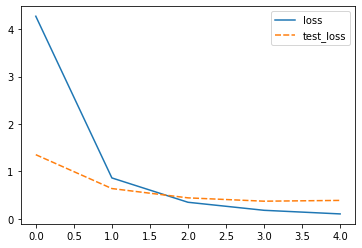

In [19]:
history = model.fit(X_train, y_train, 
                    epochs=5, 
                    validation_data=(X_score, y_score), 
                    verbose=1)

history_df = pd.DataFrame({
    'loss': history.history['loss'],
    'test_loss': history.history['val_loss']
})

sns.lineplot(data=history_df)
plt.show()

Guardando modelo

In [20]:
#Guardando modelo
model.save('benign_model.h5')

#pickle.dump(model, open('model.pkl', 'wb'))

Metricas del modelo

In [21]:
y_pred = model.predict(X_score, verbose=0)


auc = roc_auc_score(y_score, y_pred)
print('ROC AUC: %f' % auc)

ROC AUC: 0.954610


In [22]:
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

Loading model

In [23]:
malign_model = load_model('benign_model.h5')

In [24]:
classifier = KerasClassifier(malign_model, clip_values=(0, 1), use_logits=False)

Creando modelo Copycat CNN

In [25]:
copycat_cnn = CopycatCNN(classifier=classifier,
                         batch_size_fit=128,
                         batch_size_query=128,
                         nb_epochs=6,
                         nb_stolen=3000)

In [26]:
copycat_model = Sequential()

#Input Layer
copycat_model.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
copycat_model.add(layers.MaxPooling2D((1, 1)))

#Layer 2
copycat_model.add(layers.Conv2D(64, (1, 1), activation='relu'))
copycat_model.add(layers.MaxPooling2D((1, 1)))


#Final Layer
copycat_model.add(layers.Flatten())
copycat_model.add(layers.Dense(64, activation='relu'))
copycat_model.add(layers.Dense(23, activation='sigmoid'))

In [27]:
copycat_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [28]:
copycat_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Entrenando modelo con 2000 datos random

In [29]:
print(len(X_train))
indexes = np.random.permutation(len(X_train))
X_train_ccnn = X_train[indexes[:2000]]
X_score_ccnn = X_train[indexes[2000:]]
y_train_ccnn = y_train[indexes[:2000]]
y_score_ccnn = y_train[indexes[2000:]]

copycat_classifier = KerasClassifier(copycat_model, clip_values=(0, 1), use_logits=False)
copycat_classifier = copycat_cnn.extract(X_train_ccnn, y_train_ccnn, thieved_classifier=copycat_classifier)

2387


c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 2000 samples
Epoch 1/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 12.6198 - accuracy: 0.0945
Epoch 2/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 2.6349 - accuracy: 0.3270
Epoch 3/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 1.7786 - accuracy: 0.5535
Epoch 4/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 0.9427 - accuracy: 0.7830
Epoch 5/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 0.5101 - accuracy: 0.8755
Epoch 6/6
2000/2000 [==============================] - 56s 28ms/sample - loss: 0.3325 - accuracy: 0.9090


In [30]:
#Metricas del modelo Copycat CNN
print(len(X_score))
y_pred_copycat = copycat_classifier._model.evaluate(X_score, y_score)
print('Copycat CNN accuracy: ', y_pred_copycat[1])

1024


c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Copycat CNN accuracy:  0.8183594


Creando modelo KnockoffNets

In [31]:
knockoff_nets = KnockoffNets(classifier=classifier,
                             batch_size_fit=128,
                             batch_size_query=128,
                             nb_epochs=6,
                             nb_stolen=3000)

In [32]:
knockoff_model = Sequential()

#Input Layer
knockoff_model.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
knockoff_model.add(layers.MaxPooling2D((1, 1)))

#Layer 2
knockoff_model.add(layers.Conv2D(64, (1, 1), activation='relu'))
knockoff_model.add(layers.MaxPooling2D((1, 1)))


#Final Layer
knockoff_model.add(layers.Flatten())
knockoff_model.add(layers.Dense(64, activation='relu'))
knockoff_model.add(layers.Dense(23, activation='sigmoid'))

In [33]:
knockoff_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [34]:
knockoff_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Entrenando modelo con 2000 datos random

In [35]:
knockoff_classifier = KerasClassifier(knockoff_model, clip_values=(0, 1), use_logits=False)
knockoff_classifier = knockoff_nets.extract(X_train_ccnn, y_train_ccnn, thieved_classifier=knockoff_classifier)

In [36]:
#Metricas del modelo Knockoff Nets
print(len(X_score))
y_pred_knockoff = knockoff_classifier._model.evaluate(X_score, y_score)
print('Knockoff Nets accuracy: ', y_pred_knockoff[1])

1024
Knockoff Nets accuracy:  0.7861328


Protecting model

In [37]:
from art.defences.postprocessor import ReverseSigmoid
protected_classifier = KerasClassifier(malign_model, clip_values=(0,1), use_logits=False, postprocessing_defences=ReverseSigmoid(beta=1.0, gamma=0.3))

Trying to Copycat protected model

In [38]:
copycat_cnn_p = CopycatCNN(classifier=protected_classifier,
                         batch_size_fit=128,
                         batch_size_query=128,
                         nb_epochs=6,
                         nb_stolen=3000)

In [39]:
copycat_model_p = Sequential()

#Input Layer
copycat_model_p.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
copycat_model_p.add(layers.MaxPooling2D((1, 1)))

#Layer 2
copycat_model_p.add(layers.Conv2D(64, (1, 1), activation='relu'))
copycat_model_p.add(layers.MaxPooling2D((1, 1)))


#Final Layer
copycat_model_p.add(layers.Flatten())
copycat_model_p.add(layers.Dense(64, activation='relu'))
copycat_model_p.add(layers.Dense(23, activation='sigmoid'))

In [40]:
copycat_model_p.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [41]:
copycat_model_p.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
copycat_classifier_p = KerasClassifier(copycat_model_p, clip_values=(0, 1), use_logits=False)
copycat_classifier_p = copycat_cnn_p.extract(X_train_ccnn, y_train_ccnn, thieved_classifier=copycat_classifier_p)

c:\Users\jandr\AppData\Local\Programs\Python\Python310\lib\site-packages\art\defences\postprocessor\reverse_sigmoid.py:75: RuntimeWarning: divide by zero encountered in log
  perturbation_r = self.beta * (sigmoid(-self.gamma * np.log((1.0 - preds_clipped) / preds_clipped)) - 0.5)


Train on 2000 samples
Epoch 1/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 10.8167 - accuracy: 0.2040
Epoch 2/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 2.4361 - accuracy: 0.3550
Epoch 3/6
2000/2000 [==============================] - 60s 30ms/sample - loss: 1.8188 - accuracy: 0.4690
Epoch 4/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 1.4203 - accuracy: 0.6000
Epoch 5/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 1.1448 - accuracy: 0.6755
Epoch 6/6
2000/2000 [==============================] - 58s 29ms/sample - loss: 0.9196 - accuracy: 0.7415


In [43]:
#Metricas del modelo Copycat CNN
print(len(X_score))
y_pred_copycat_p = copycat_classifier_p._model.evaluate(X_score, y_score)
print('(Protected) Copycat CNN accuracy: ', y_pred_copycat_p[1])

1024
Copycat CNN accuracy:  0.0029296875


Trying to Knockoff protected model

In [44]:
knockoff_nets_p = KnockoffNets(classifier=protected_classifier,
                             batch_size_fit=128,
                             batch_size_query=128,
                             nb_epochs=6,
                             nb_stolen=3000)

In [45]:
knockoff_model_p = Sequential()

#Input Layer
knockoff_model_p.add(layers.Conv2D(128, (1, 1), activation='relu', input_shape=(128, 128, 3)))
knockoff_model_p.add(layers.MaxPooling2D((1, 1)))

#Layer 2
knockoff_model_p.add(layers.Conv2D(64, (1, 1), activation='relu'))
knockoff_model_p.add(layers.MaxPooling2D((1, 1)))


#Final Layer
knockoff_model_p.add(layers.Flatten())
knockoff_model_p.add(layers.Dense(64, activation='relu'))
knockoff_model_p.add(layers.Dense(23, activation='sigmoid'))

In [46]:
knockoff_model_p.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 128, 128)     512       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 128, 128, 128)    0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [47]:
knockoff_model_p.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
knockoff_classifier_p = KerasClassifier(knockoff_model_p, clip_values=(0, 1), use_logits=False)
knockoff_classifier_p = knockoff_nets_p.extract(X_train_ccnn, y_train_ccnn, thieved_classifier=knockoff_classifier_p)

In [49]:
#Metricas del modelo Knockoff Nets
print(len(X_score))
y_pred_knockoff_p = knockoff_classifier_p._model.evaluate(X_score, y_score)
print('(Protected) Knockoff Nets accuracy: ', y_pred_knockoff_p[1])

1024
Knockoff Nets accuracy:  0.0078125
